In [1]:
# https://www.kaggle.com/code/hinepo/pytorch-tutorial-for-image-classification?scriptVersionId=237618061    09.02 im gonna see and try to write and understand this approach too

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=ToTensor(),
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=ToTensor(),
    download=True
)

In [5]:
classes = test_dataset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

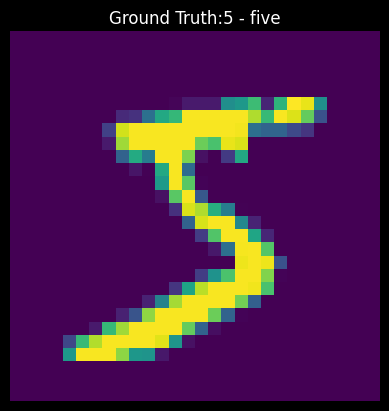

In [6]:
img, gts = train_dataset[0]

plt.imshow(img[0].squeeze())
plt.title(f'Ground Truth:{classes[gts]}')
plt.axis('off')
plt.show()

In [7]:
img.shape

torch.Size([1, 28, 28])

In [8]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f9b39466a50>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9b3c52e490>)

In [11]:
class HandwritingRecognizeModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.classifier(x)
        return x


model = HandwritingRecognizeModel(img.shape[0], 30, 10).to(device)

from torchinfo import summary

summary(model, input_size=(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
HandwritingRecognizeModel                [32, 10]                  --
├─Sequential: 1-1                        [32, 30, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 30, 28, 28]          300
│    └─ReLU: 2-2                         [32, 30, 28, 28]          --
│    └─Conv2d: 2-3                       [32, 30, 28, 28]          8,130
│    └─ReLU: 2-4                         [32, 30, 28, 28]          --
│    └─MaxPool2d: 2-5                    [32, 30, 14, 14]          --
├─Sequential: 1-2                        [32, 30, 7, 7]            --
│    └─Conv2d: 2-6                       [32, 30, 14, 14]          8,130
│    └─ReLU: 2-7                         [32, 30, 14, 14]          --
│    └─Conv2d: 2-8                       [32, 30, 14, 14]          8,130
│    └─ReLU: 2-9                         [32, 30, 14, 14]          --
│    └─MaxPool2d: 2-10                   [32, 30, 7, 7]            --
├─Seq

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def acc_fn(y_pred, y_true):
    equals = torch.eq(y_pred, y_true).sum().item()
    return equals / len(y_true) * 100

In [10]:
def train_steps(
        dataloader: DataLoader,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        loss_fn,
        acc_fn,
        device=device
):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (img, gts) in enumerate(dataloader):
        img, gts = img.to(device), gts.to(device)
        label_pred = model(img)

        loss = loss_fn(label_pred, gts)
        train_loss += loss.item()
        train_acc += acc_fn(gts, label_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(train_loss, train_acc)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [11]:
def test_steps(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn,
        acc_fn,
        device=device
):
    model.to(device)
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (img, gts) in enumerate(dataloader):
            img, gts = img.to(device), gts.to(device)
            label_pred = model(img)
            test_loss += loss_fn(label_pred, gts)
            test_acc += acc_fn(gts, label_pred.argmax(dim=1))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [12]:
def model_eval(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn,
        acc_fn,
        device=device
):
    model.to(device)
    loss, acc = 0, 0
    with torch.inference_mode():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device),
            prediction = model(x)
            loss += loss_fn(prediction, y)
            acc += acc_fn(prediction.argmax(dim=1), y)

        loss /= len(dataloader)
        acc /= len(dataloader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_acc": acc}

In [13]:
torch.manual_seed(42)
epochs = 4

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    train_steps(
        dataloader=train_dataloader,
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        acc_fn=acc_fn,
        device=device
    )
    test_steps(
        dataloader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        acc_fn=acc_fn,
        device=device
    )

Epoch 1
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After la

In [14]:
model_res = model_eval(model=model, dataloader=test_dataloader, loss_fn=loss_fn, acc_fn=acc_fn, device=device)
model_res

After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 tor

{'model_name': 'HandwritingRecognizeModel',
 'model_loss': tensor(0.0347, device='cuda:0'),
 'model_acc': 98.82188498402556}

In [15]:
def make_pred_probs(
        model: nn.Module,
        data: list,
        device=device
):
    predictions = []
    with torch.inference_mode():
        model.to(device)
        for img in data:
            img = torch.unsqueeze(img, dim=0).to(device)
            logits = model(img)
            probs = torch.softmax(logits.squeeze(), dim=0)
            predictions.append(probs.cpu())

    return torch.stack(predictions)

In [16]:
import random

random.seed(42)
test_labels, test_samples = [], []

for sample, label in random.sample(list(test_dataset), 9):
    test_samples.append(sample)
    test_labels.append(label)

print(
    f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


In [17]:
prediction_probs = make_pred_probs(
    model=model,
    data=test_samples
)
prediction_probs[:2], prediction_probs.shape

After layer1 torch.Size([1, 30, 14, 14])
After layer2 torch.Size([1, 30, 7, 7])
After layer1 torch.Size([1, 30, 14, 14])
After layer2 torch.Size([1, 30, 7, 7])
After layer1 torch.Size([1, 30, 14, 14])
After layer2 torch.Size([1, 30, 7, 7])
After layer1 torch.Size([1, 30, 14, 14])
After layer2 torch.Size([1, 30, 7, 7])
After layer1 torch.Size([1, 30, 14, 14])
After layer2 torch.Size([1, 30, 7, 7])
After layer1 torch.Size([1, 30, 14, 14])
After layer2 torch.Size([1, 30, 7, 7])
After layer1 torch.Size([1, 30, 14, 14])
After layer2 torch.Size([1, 30, 7, 7])
After layer1 torch.Size([1, 30, 14, 14])
After layer2 torch.Size([1, 30, 7, 7])
After layer1 torch.Size([1, 30, 14, 14])
After layer2 torch.Size([1, 30, 7, 7])


(tensor([[5.4384e-10, 6.2036e-08, 1.0000e+00, 2.0640e-07, 2.4057e-17, 1.5665e-14,
          3.2304e-14, 2.8021e-06, 1.5414e-07, 3.9026e-11],
         [2.7921e-06, 9.8944e-01, 6.6800e-05, 2.8375e-06, 3.7705e-05, 3.7363e-04,
          3.7918e-04, 1.1267e-04, 9.1364e-03, 4.4886e-04]]),
 torch.Size([9, 10]))

In [18]:
predictions = prediction_probs.argmax(dim=1)
predictions

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

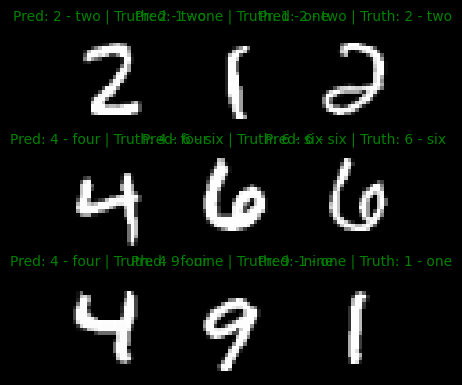

In [19]:
plt.figure(figsize=(4.5, 4.5))
r, c = 3, 3
for i, sample in enumerate(test_samples):
    plt.subplot(r, c, i + 1)
    plt.imshow(sample.squeeze(), cmap="gray")
    label_pred = classes[predictions[i]]
    gts = classes[test_labels[i]]
    title_text = f"Pred: {label_pred} | Truth: {gts}"
    if label_pred == gts:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis('off')
plt.show()

In [20]:
from tqdm.auto import tqdm

predictions = []
for x, y in tqdm(test_dataloader):
    x, y = x.to(device), y.to(device)
    logits = model(x)
    prediction = torch.softmax(logits, dim=1).argmax(dim=1)
    predictions.append(prediction.cpu())

predictions_tensor = torch.cat(predictions)
predictions_tensor.shape, predictions_tensor

  0%|          | 0/313 [00:00<?, ?it/s]

After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 torch.Size([32, 30, 14, 14])
After layer2 torch.Size([32, 30, 7, 7])
After layer1 tor

(torch.Size([10000]), tensor([7, 2, 1,  ..., 4, 5, 6]))

In [21]:
try:
    import torchmetrics, mlxtend

    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend

    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.24.0


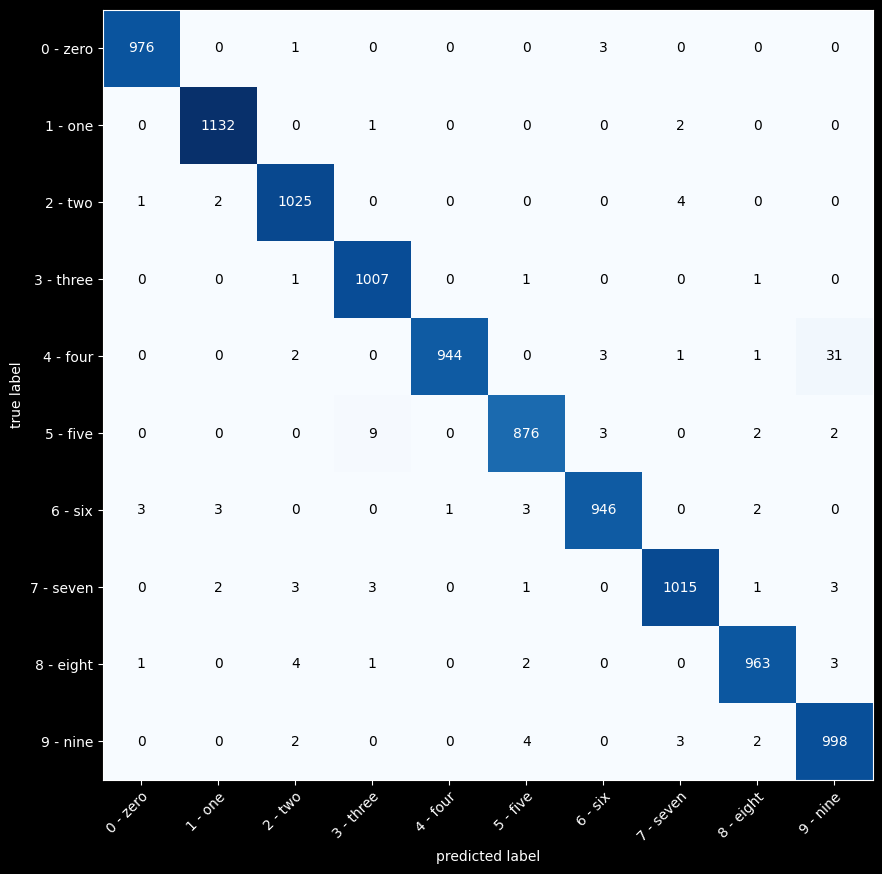

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=predictions_tensor,
                         target=test_dataset.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=classes,
    figsize=(10, 10),
)


# print(test_dataloader, "\n\n", test_dataloader.dataset, "\n\n", test_dataloader.dataset.targets, "\n\n",
#       test_dataloader.dataset.classes)

In [22]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
import random

class CustomDataset(Dataset):
  def __init__(self, target_dir, transforms = None, split_ratio = 0.8, is_train_split = True, glob_pattern = "*/*.jpg", known_class_names=None):
    self.transforms = transforms
    self.is_train_split = is_train_split # Store this attribute to use in __getitem__
    all_paths = list(Path(target_dir).glob(glob_pattern))

    random.shuffle(all_paths)

    if is_train_split is not None:
      split_idx = int(len(all_paths) * split_ratio)
      if is_train_split:
        self.paths = all_paths[:split_idx]
      else:
        self.paths = all_paths[split_idx:]
      self.class_names = sorted(entry.name for entry in target_dir.iterdir() if entry.is_dir())
    else:
      self.paths = all_paths
      self.class_names = known_class_names if known_class_names else []

    self.class_idx = {name: idx for idx, name in enumerate(self.class_names)}


  def __len__(self):
    return len(self.paths)


  def load_image(self, idx: int):
    image_path = self.paths[idx]
    return Image.open(image_path)


  def __getitem__(self, index: int):
    img = self.load_image(index)
    if self.transforms:
      img = self.transforms(img)

    if self.is_train_split is not None: # For train/validation sets where labels are in subdirectories
      class_name = self.paths[index].parent.name
      class_idx = self.class_idx[class_name]
    else: # For test sets where labels are not derived from subdirectories (or are unknown)
      class_idx = -1 # A dummy label, as the actual label isn't known from the path

    return img, class_idx
